In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

Analysis for 2 groups with a focus to see if there is a connection between these companies and if they are worth investing into
Apple, Google, Microsoft - The usual big 3, how connected are they
Nvidia, AMD, Intel - Microcontrollers and AI boom

Desire to invest into Microsoft, Amazon, Intel, Goldman Sachs, and Apple as my trades

In [163]:
cpu_list = ['NVDA', 'INTC','AMD']

comp_list = ['MSFT','GOOG', 'AAPL']

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [164]:
for stock in cpu_list:
    globals()[stock] = yf.download(stock, start, end)

df_nvda = globals()['NVDA']
df_amd = globals()['AMD']
df_intc = globals()['INTC']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [165]:
for stock in comp_list:
    globals()[stock] = yf.download(stock, start, end)

df_msft = globals()['MSFT']
df_goog = globals()['GOOG']
df_aapl = globals()['AAPL']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [166]:
globals()['GS'] = yf.download('GS', start, end)
df_gs = globals()['GS'] 

[*********************100%%**********************]  1 of 1 completed


#### Model Preparation 

Spreads data to five years instead of three years

In [167]:
def preprocess_data(stock_symbol, epochs=100, batch_size=32, window_size=60):
    # Fetch data
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)
    df = pdr.get_data_yahoo(stock_symbol, start=start, end=end)

    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * .95))

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size])

    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    test_data = scaled_data[training_data_len - window_size:, :]
    test_set = []
    for i in range(window_size, len(test_data)):
        test_set.append(test_data[i-window_size:i, 0])

    test_set = np.array(test_set)
    test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1))

    prediction = model.predict(test_set)
    scaled_pred = scaler.inverse_transform(prediction)

    # Prepare results
    valid = data[training_data_len:]
    valid['Predictions'] = scaled_pred

    return df, valid, scaled_pred

## Analysis of Intel, Nvidia, and AMD - Chip Industry

### Closing Prices

In [168]:
col_nvda = df_nvda['Adj Close']
col_amd = df_amd['Adj Close']
col_intc = df_intc['Adj Close']

col_df = pd.concat([col_nvda, col_amd, col_intc], axis=1)
col_df.columns = ['NVDA', 'AMD', 'INTC']

#### Performance Summary

In [169]:
fig = px.line(col_df, y=['NVDA', 'AMD', 'INTC'], title = 'Closing Prices of Stocks')
fig.show()

To be seen in the chart above, Nvidia's stock performance feels unnatural considering the stock performance of chipmaker companies. There is a possibility that Nvidia's stock may drop once it reaches the 1k dollar peak considering how close it is.

#### Individual Performance

In [170]:
fig_nvda = px.line(df_nvda, y=['Adj Close'], title='Nvidia Stock Performance')

fig_amd = px.line(df_amd, y=['Adj Close'], title='AMD Stock Performance')

fig_intc = px.line(df_intc, y=['Adj Close'], title='Intel Stock Performance')

In [115]:
fig_nvda.show()
fig_amd.show()
fig_intc.show()

It can be seen that there are certain drops in stock price for each company on the same day. Such as March 7th 2024, where each stock had its price experience a suddden spike in the semiconductor industry when Broadcom (AVGO) had its price target raised. 

It can be noticed that any annoucement in the industry can deeply affect other stock prices.

### Simple Moving Average (SMA)

Moving Average is used to smooth out the price data by creating an updated average price. Allowing us to see if the stock is going below the average due to fluctuations or random impacts in a certain time frame.

100 days can be used to represent a smaller price compared to the rest of the year. 

50 days represent a level that the stock is best to go under. 

10 days represent a close following of the stock and capture trends.

In [116]:
ma_day = [10, 50, 100]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_nvda[column_name] = df_nvda['Adj Close'].rolling(ma).mean()
    df_amd[column_name] = df_amd['Adj Close'].rolling(ma).mean()
    df_intc[column_name] = df_intc['Adj Close'].rolling(ma).mean()


Text(0.5, 1.0, 'Intel Moving Average')

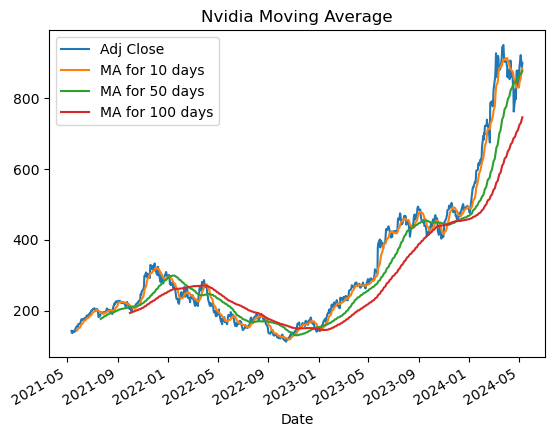

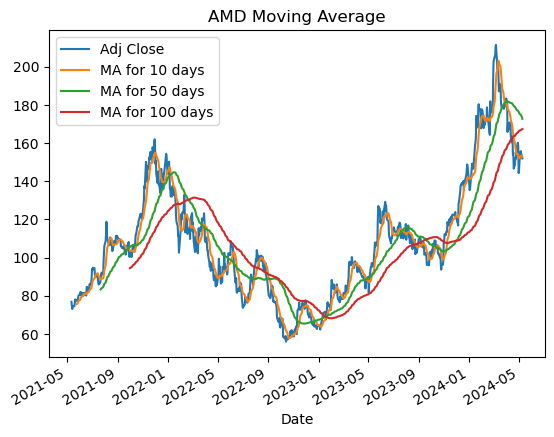

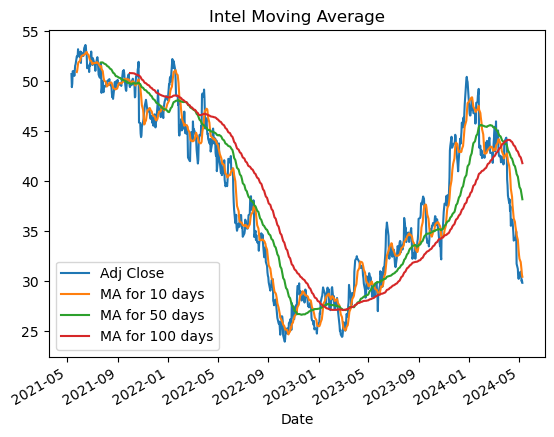

In [117]:
df_nvda[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Nvidia Moving Average")

df_amd[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("AMD Moving Average")

df_intc[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Intel Moving Average")

### Volatility Calculation

Volatility Calculation measures the change in variance in a stock's return. This can be used to compare the level of risk for stocks and comparison.

In [118]:
min_periods = 75
vol_nvda = df_nvda['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)
vol_amd = df_amd['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)
vol_intc = df_intc['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)

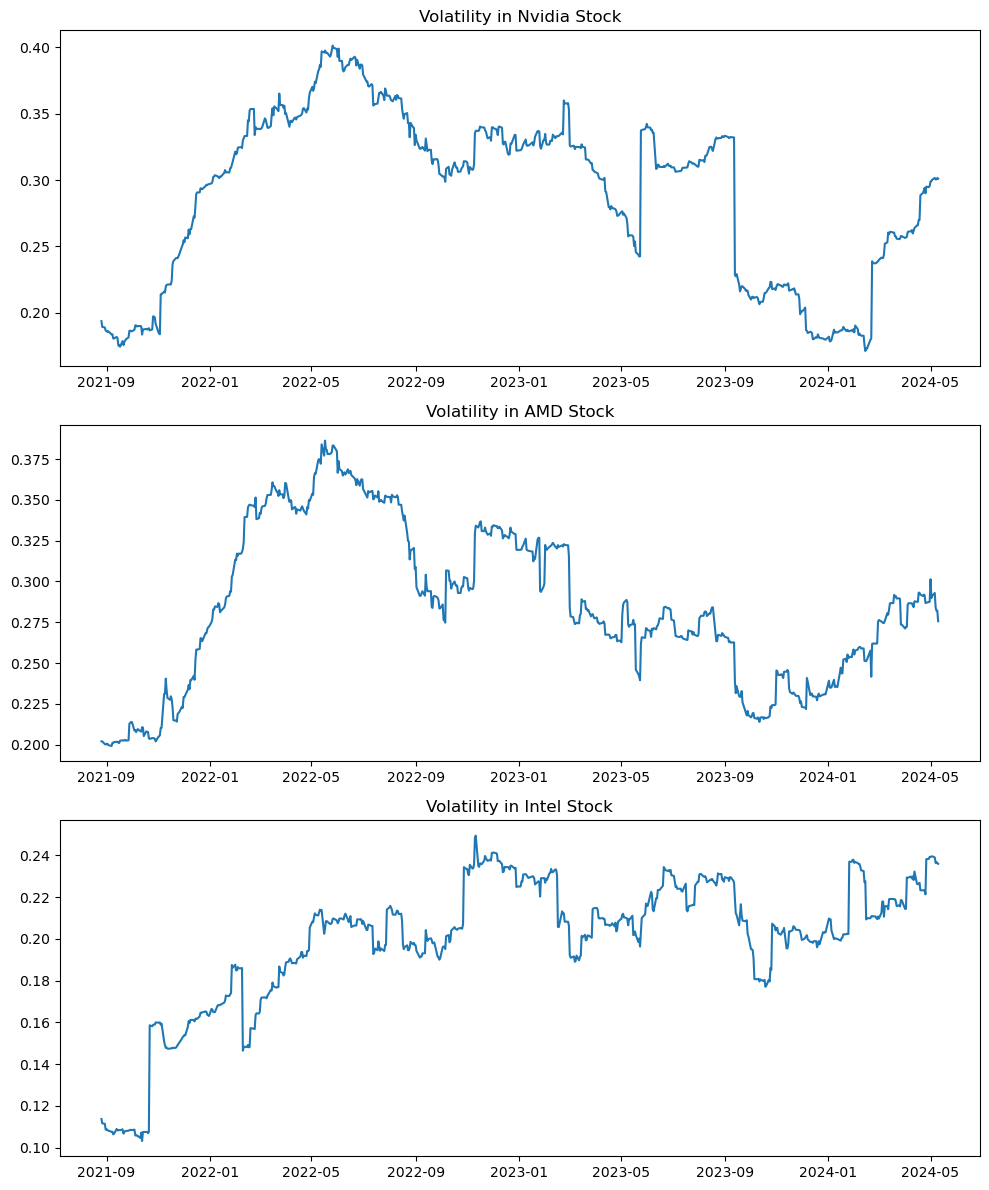

In [119]:
fig, axs = plt.subplots(3, 1, figsize=(10,12))

axs[0].plot(vol_nvda)
axs[0].set_title('Volatility in Nvidia Stock')

axs[1].plot(vol_amd)
axs[1].set_title('Volatility in AMD Stock')

axs[2].plot(vol_intc)
axs[2].set_title('Volatility in Intel Stock')

plt.tight_layout()
plt.show()

Based on the Volatiliy charts, it can be seen the correlation that the 3 companies may have. Although Intel does not seem as closely reactive as compared to the similar points of rise and falls that Nvidia and AMD have. 

The most notable point of correlation is 2022-01 to 2022-09 where we can see a noticeable rise and in stock volatility and then seeing it significantly fall around the same time for both. There is a better seen correlation between AMD and Intel in certain points in time as well such as 2023-05 to 2023-09 as well.

But overall between all three companies, we can see points in time where each stock would have a significant rise or drop in their own way at the same time such as 2023-09 for each company. 

Nvidia is seen to have the most active volatility out of the three available stocks with its sudden drops and rises. 

### Daily Return

In [150]:
daily_close = df_nvda['Adj Close']
daily_pct_nvda = daily_close.pct_change()
daily_pct_nvda.fillna(0,inplace=True)

daily_close = df_amd['Adj Close']
daily_pct_amd = daily_close.pct_change()
daily_pct_amd.fillna(0,inplace=True)

daily_close = df_intc['Adj Close']
daily_pct_intc = daily_close.pct_change()
daily_pct_intc.fillna(0,inplace=True)

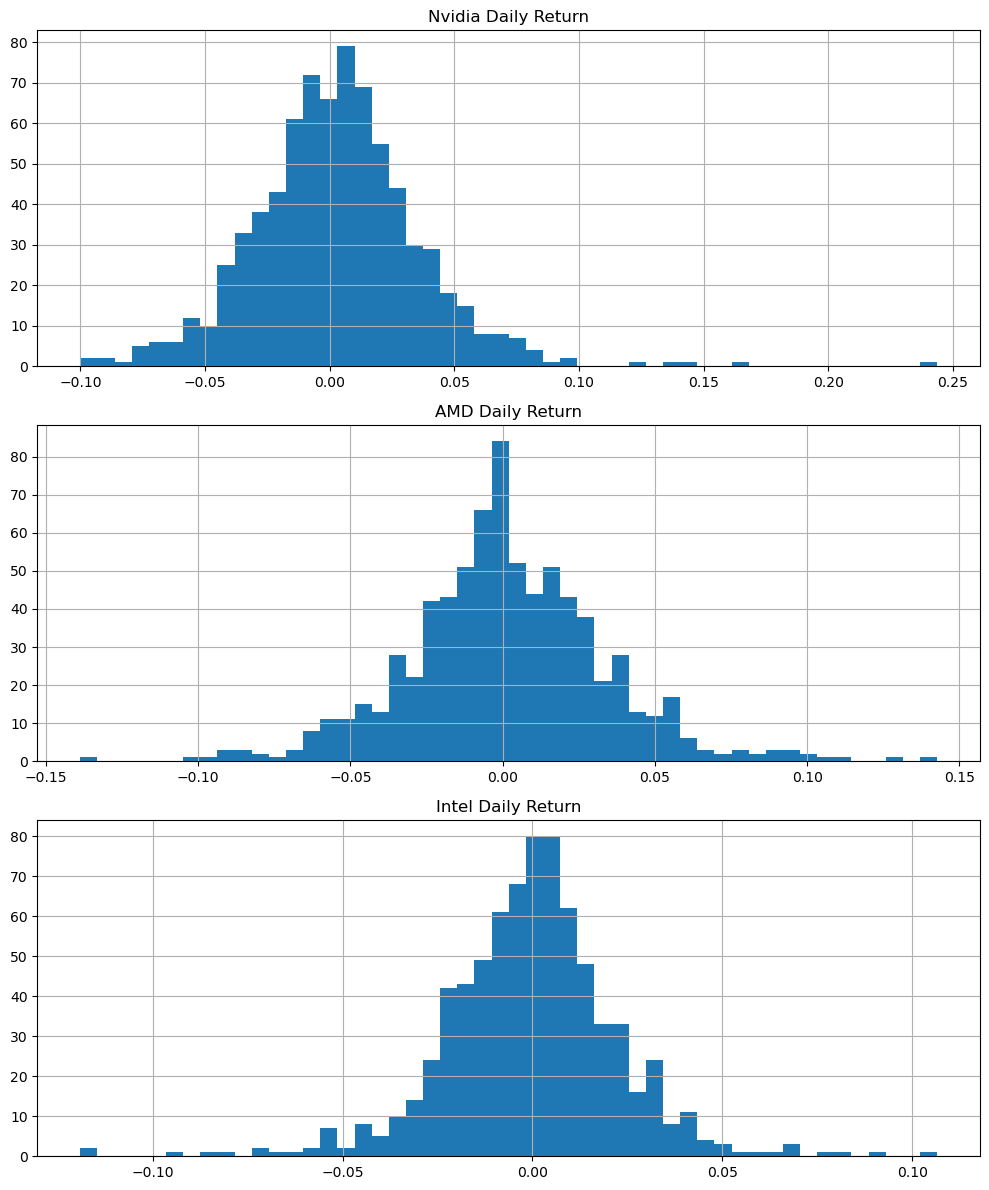

In [154]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

daily_pct_nvda.hist(ax=axs[0], bins=50)
axs[0].set_title('Nvidia Daily Return')

daily_pct_amd.hist(ax=axs[1], bins=50)
axs[1].set_title('AMD Daily Return')

daily_pct_intc.hist(ax=axs[2], bins=50)
axs[2].set_title('Intel Daily Return')

plt.tight_layout()
plt.show()

### Prediction

#### Nvidia Prediction

In [120]:
df_nvda_5, valid_nvda, pred = preprocess_data(cpu_list[0])

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 28ms/step


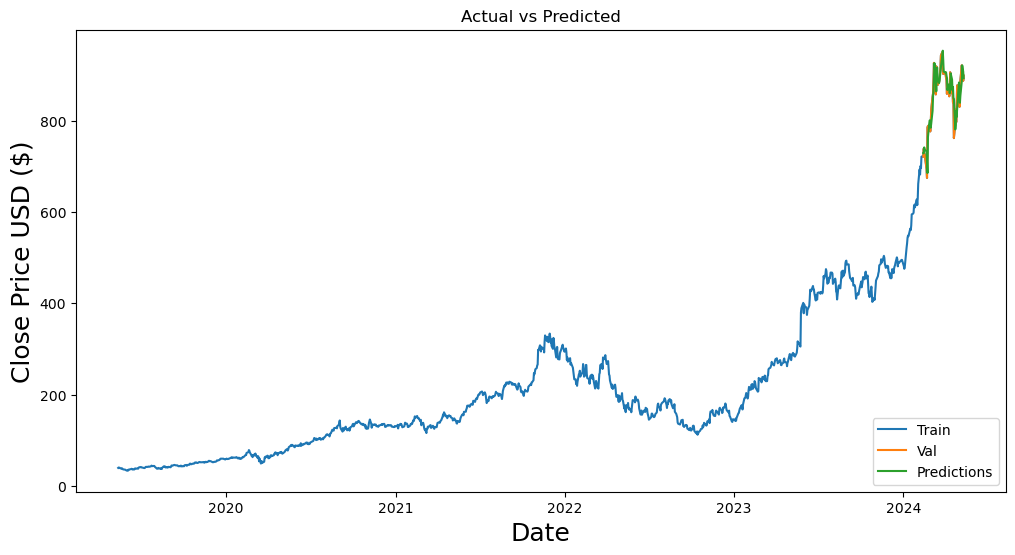

In [196]:
# Visualize the data
plt.figure(figsize=(12,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_nvda_5['Close'])
plt.plot(valid_nvda[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# df_nvda_5 shows the real closing prices, Val from valid_nvda is the testing data portion used to test if the model can accurately predict the closing price, Predictions are the real predictions from the model. 100 epochs gives the best accuracy while saving time.

In [122]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_nvda_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Hold the stock.


#### AMD Prediction

In [123]:
df_amd_5, valid_amd, pred_amd = preprocess_data(cpu_list[2])

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 11ms/step


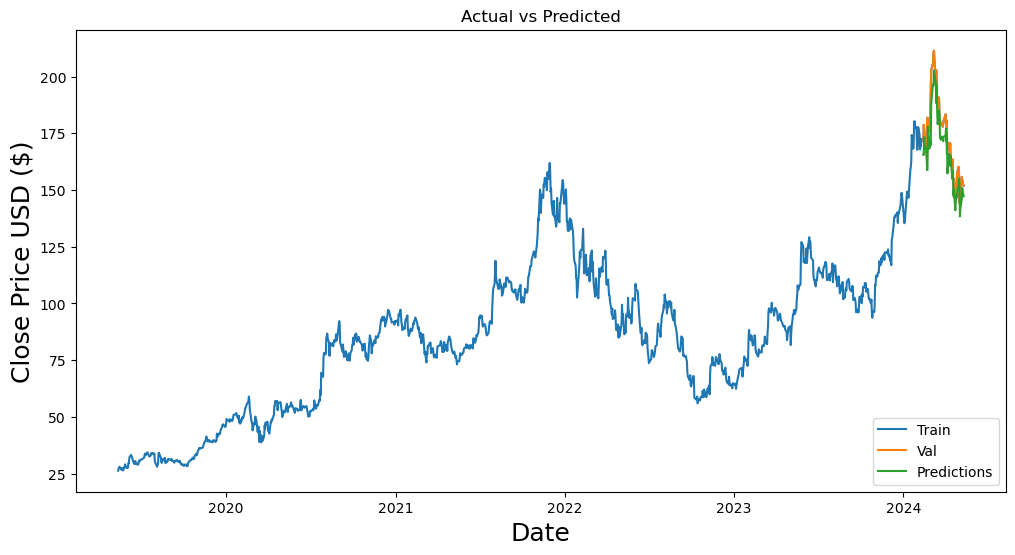

In [124]:
# Visualize the data
plt.figure(figsize=(12,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_amd_5['Close'])
plt.plot(valid_amd[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [125]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_amd_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_amd[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Consider selling the stock.


#### Intel Prediction

In [126]:
df_intc_5, valid_intc, pred_intc = preprocess_data(cpu_list[1])

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 11ms/step


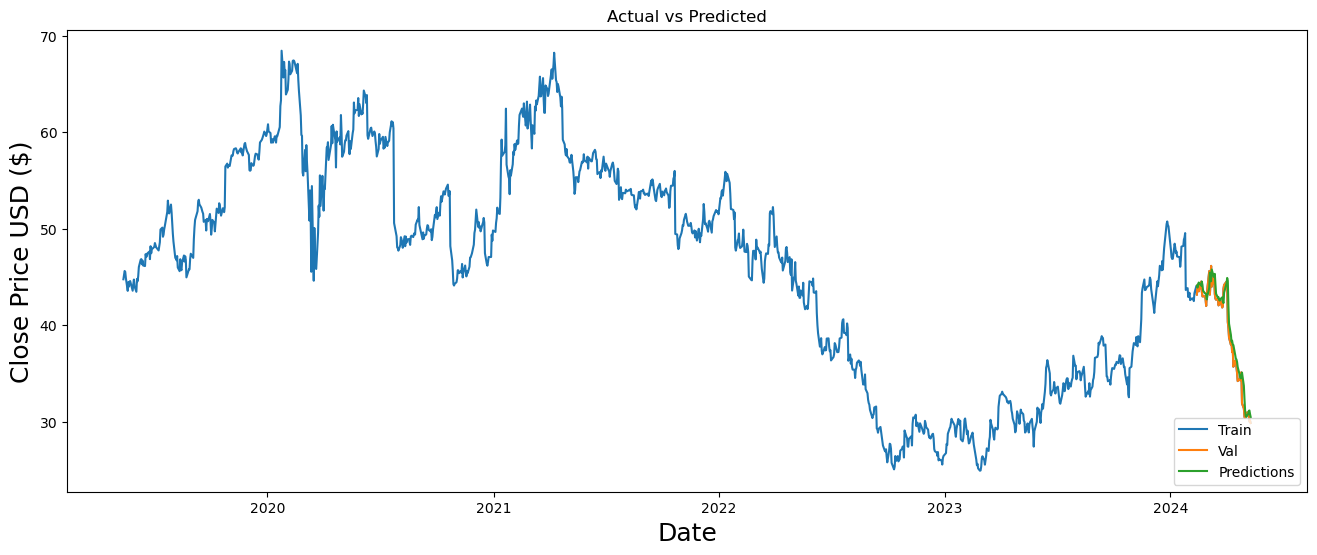

In [127]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_intc_5['Close'])
plt.plot(valid_intc[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [128]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_intc_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_intc[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Hold the stock.


### Conclusion

When analyzing the correlation between the three stocks and their performance, Nvidia is still a viable good choice for futher investment considering its ever increasing price, it is also a good option to sell as well or hold onto the current amount of the stock considering how fast the stock is rising. A return in investment would be seen due to it's unnatural rise and how close it is to reaching $1000 dollars, there is a possibility that most would sell and thus causing the stock to drop to a more investable level if you choose to wait. Only invest if you have the funds to purchase such an expensive stock. 

AMD and Intel are not as well performing as compared to Nvidia but hold a more reasonable price and promise. Among both AMD and Intel, Intel does not show the same promise it used to have 3 years before, reaching the lowest it has ever been within the last 5 years. Compared to its competitors, Intel does not have a strong foothold in the Chipmaker market as compared to Nvidia and AMD and has been struggling to recover or even catch up to AMD. Holding onto any stock you may have is the best course of action considering there is a chance it may rise again given Intels reputation. If you choose to buy right now, Intel will most likely still be going down given its trend line so it would be best to wait still.

This leads to the conclusion following predictions and stock history, that AMD may be a wise further investment strategy. Considering its still viable position in the Chip market and how close its performance in stock volatility it is to Nvidia. It has the capability to rise higher in stock price and provide a return in investment. Whenever Nvidia will experience a significant rise in the market, AMD will also feel it as well. Although the same can go for Intel, its performance proves it struggles to return to the glory it used to have in the market. Given the prediction and AMD's current trend line, the decision to hold onto your available stock is a good approach. However it can be seen that AMD's trend line is beginning to curve back up again. Making it a good choice to invest now before it recovers or hold onto any stock that you already have. 

From this analysis, I have chosen to hold my stock for Nvidia, not to buy Intel stock, and decide to further invest into AMD given its chance to recover and close connection to Nvidia. These Decisions were done in 5/10/24.

## Analysis of Apple, Google, Microsoft - The Popular Staple Tech Companies

### Closing Prices

In [176]:
col_msft = df_msft['Adj Close']
col_goog = df_goog['Adj Close']
col_aapl = df_aapl['Adj Close']

col_df = pd.concat([col_msft,col_goog,col_aapl], axis=1)
col_df.columns = ['MSFT','GOOG', 'AAPL']

#### Performance Summary

In [177]:
fig = px.line(col_df, y=['MSFT','GOOG', 'AAPL'], title='Closing Prices of Stocks')
fig.show()

To be seen in the chart above, Microsoft's stock is seen to manage far better as compared to the other popular tech company stocks in the market such as Google, and Apple. With most of the other stocks remaning around the same range between 150 - 200 dollars. One example for Microsoft's high stocks may be because Microsoft holds itself as the staple for standard computers considering many people use Windows for a variety of purposes. Apple Macs and Google Chromebooks hold their own respective audience as well but can either cost too much or not hold as much use as compared to a Windows machine. 

#### Individual Performance

In [178]:
fig_msft = px.line(df_msft, y=['Adj Close'], title='Microsoft Stock Performance')

fig_goog = px.line(df_intc, y=['Adj Close'], title='Google Stock Performance')

fig_aapl = px.line(df_aapl, y=['Adj Close'], title='Apple Stock Performance')

In [195]:
fig_msft.show()
fig_goog.show()
fig_aapl.show()

In terms of individual stock performance, we can see a clear picture in how the companies are handling in the industry right now. Microsoft is doing great in its stock performance over the years with its gradual rise. Releasing a great earnings report in March 31st 2024 that shows their revenue was 61.9 billion dollars and increased by 17% as well as their operating income and net income increasing by 23% and 20% respectively. Setting itself to be the most valuable company in the world, overtaking Apple. 

Google stock performance has been able to recover over the years. Experiencing a low in stock price in 2023 after investors disliked their earnings report. Causing a "two-day selloff" in tech stocks. Google was able to recover for a short period of time but is now facing another downward trend. The reason being is because of the worries of AI. After experiencing controversial errors with their Gemini AI regarding racist views of individuals. Google experienced a stock fall of 2.8%.

Apple stock can be seen to be managing better than Google although experiencing its own lows in correlation to earnings reports that drop around those times. Experiencing a revenue slide in 2023 which was due to reports stating four straight quarters of declining sales. Aligning with the hardware troubles that Apple experienced in 2023 with their smartphones and PCs especially with their controversy with their new series of smartphones, they were able to drastically recover during Summer 2023. Their stock recently having a spike up after announcing their new M4 chip.

Considering Apple competition with Microsoft, there is a correlatio between the two companies that causes a stock to either drop or rise depending on the other company's annoucements. One such example is an article regarding the "AI revolution" and its approach to our lives coming in faster than ever anticipated. This article lead to a 0.69% drop in stock for Apple but a rise by 0.59% for Microsoft. As well as a drop in stock for Google by 0.75% regarding OpenAI's annoucement that may steal the hype for Google I/O. Overall, it may seem that Microsoft is viewed as a default safe choice considering it's popularity, reputation, and handle on multiple industries that allow them to be a good investment choice compared to other big name companies. Whenever something come that may affect companies such as Apple or Google, Microsoft experiences a small rise in stock price from it.


### Simple Moving Average (SMA)

Moving Average is used to smooth out the price data by creating an updated average price. Allowing us to see if the stock is going below the average due to fluctuations or random impacts in a certain time frame.

100 days can be used to represent a smaller price compared to the rest of the year. 

50 days represent a level that the stock is best to go under. 

10 days represent a close following of the stock and capture trends.

In [180]:
ma_day = [10, 50, 100]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_msft[column_name] = df_msft['Adj Close'].rolling(ma).mean()
    df_goog[column_name] = df_goog['Adj Close'].rolling(ma).mean()
    df_aapl[column_name] = df_aapl['Adj Close'].rolling(ma).mean()

Text(0.5, 1.0, 'Apple Moving Average')

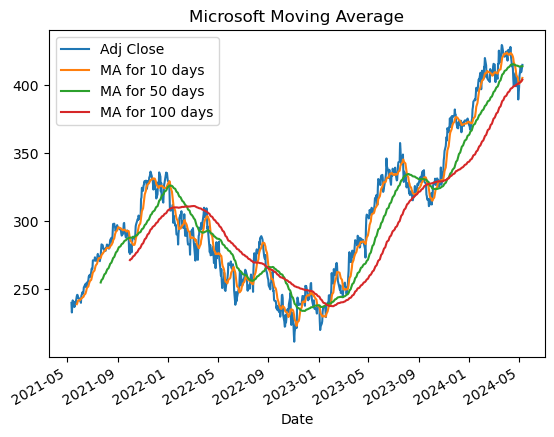

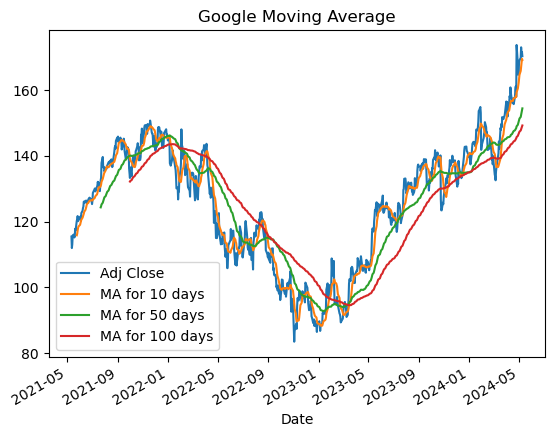

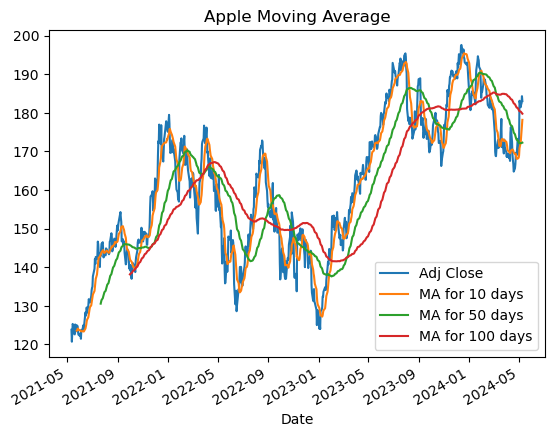

In [181]:
df_msft[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Microsoft Moving Average")

df_goog[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Google Moving Average")

df_aapl[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Apple Moving Average")

### Volatility Calculation

Volatility Calculation measures the change in variance in a stock's return. This can be used to compare the level of risk for stocks and comparison.

In [182]:
min_periods = 75
vol_msft = df_msft['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)
vol_goog = df_goog['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)
vol_aapl = df_aapl['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)

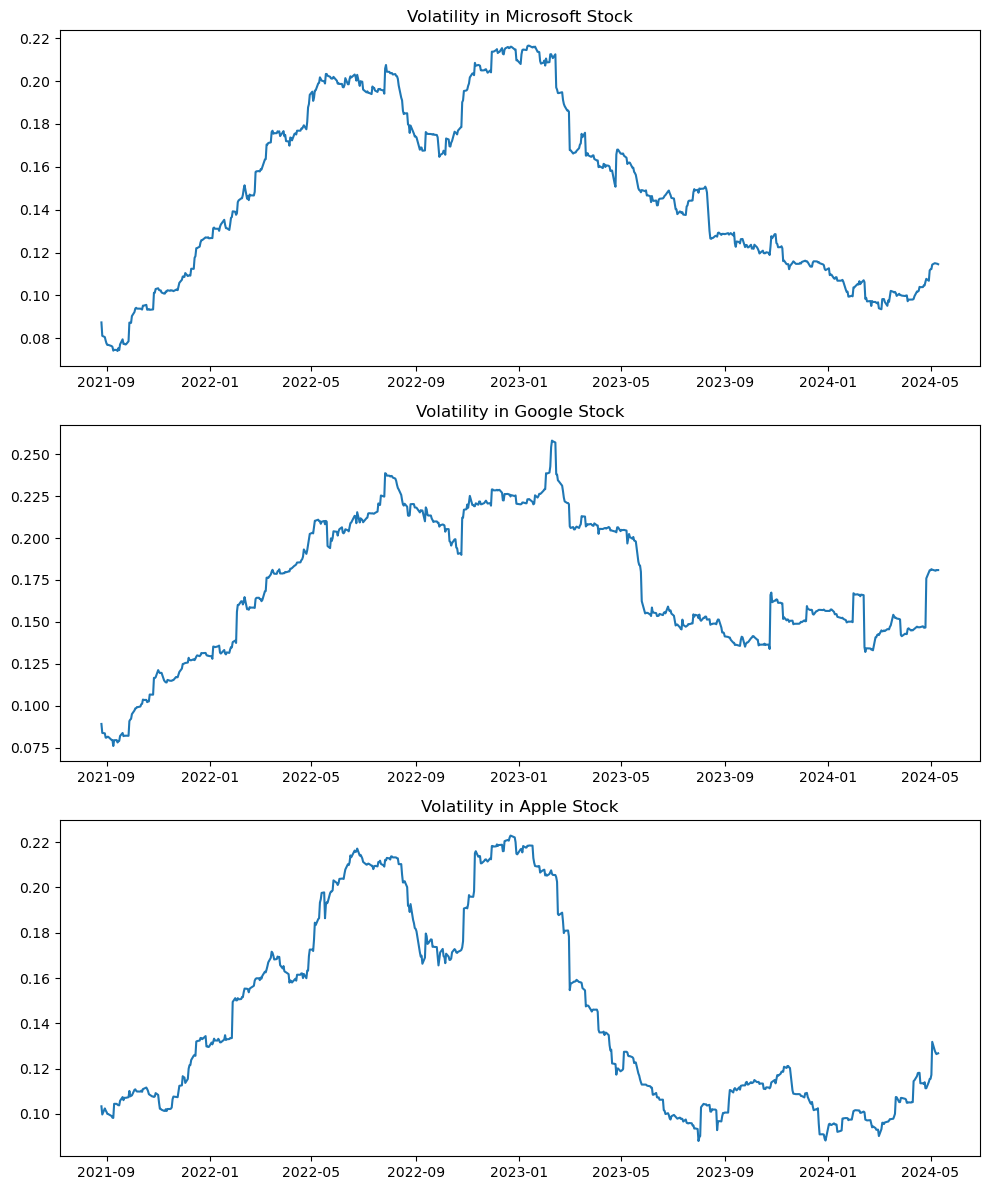

In [183]:
fig, axs = plt.subplots(3, 1, figsize=(10,12))

axs[0].plot(vol_msft)
axs[0].set_title('Volatility in Microsoft Stock')

axs[1].plot(vol_goog)
axs[1].set_title('Volatility in Google Stock')

axs[2].plot(vol_aapl)
axs[2].set_title('Volatility in Apple Stock')

plt.tight_layout()
plt.show()

Viewing the volatility of each stock, Microsoft is seen to surprisingly stablize and reduce in volatility considering it rise in stock seen in the previous table regarding the closing price of stocks. As compared to the volatility seen in Google and Apple, Apple experienced incredible spikes between 2022 and 2023 but then experienced a drop in volatility to present day that is only now increaseing, reflecting the moving average as it is now experiencing a upward trend and beginning to beat it's moving average.

Google has experienced the most significant volatitlity to present day in coreelation to its moving average, Google has a chance in increasing in stock price and going past its average and reaching a positive trend. Leading more to invest and increase the stock's volatility for a possible drop. 

### Daily Return

In [184]:
daily_close = df_msft['Adj Close']
daily_pct_msft = daily_close.pct_change()
daily_pct_msft.fillna(0,inplace=True)

daily_close = df_goog['Adj Close']
daily_pct_goog = daily_close.pct_change()
daily_pct_goog.fillna(0,inplace=True)

daily_close = df_aapl['Adj Close']
daily_pct_aapl = daily_close.pct_change()
daily_pct_aapl.fillna(0,inplace=True)

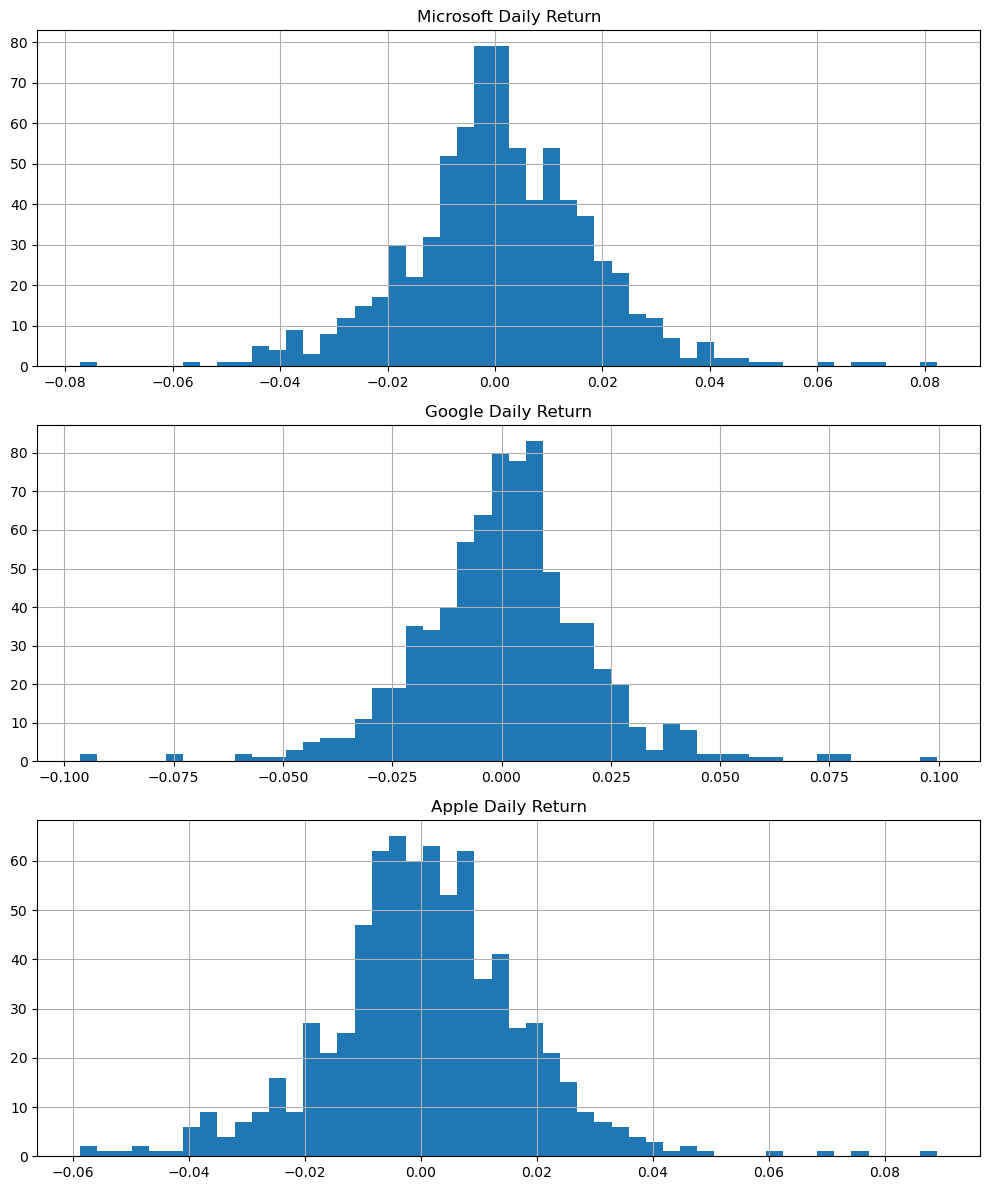

In [185]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

daily_pct_msft.hist(ax=axs[0], bins=50)
axs[0].set_title('Microsoft Daily Return')

daily_pct_goog.hist(ax=axs[1], bins=50)
axs[1].set_title('Google Daily Return')

daily_pct_aapl.hist(ax=axs[2], bins=50)
axs[2].set_title('Apple Daily Return')

plt.tight_layout()
plt.show()

### Prediction

#### Microsoft Prediction

In [186]:
df_msft_5, valid_msft, pred_msft = preprocess_data(comp_list[0])

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 12ms/step


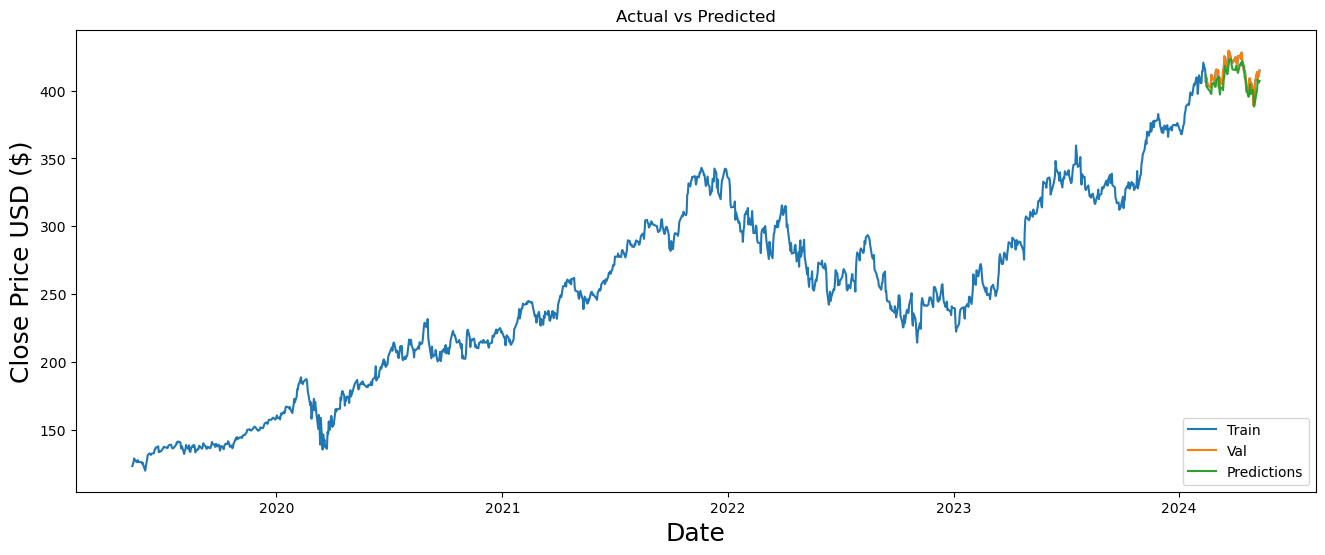

In [187]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_msft_5['Close'])
plt.plot(valid_msft[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [188]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_msft_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_msft[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Hold the stock.


#### Google Prediction

In [189]:
df_goog_5, valid_goog, pred_goog = preprocess_data(comp_list[2])

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 18ms/step


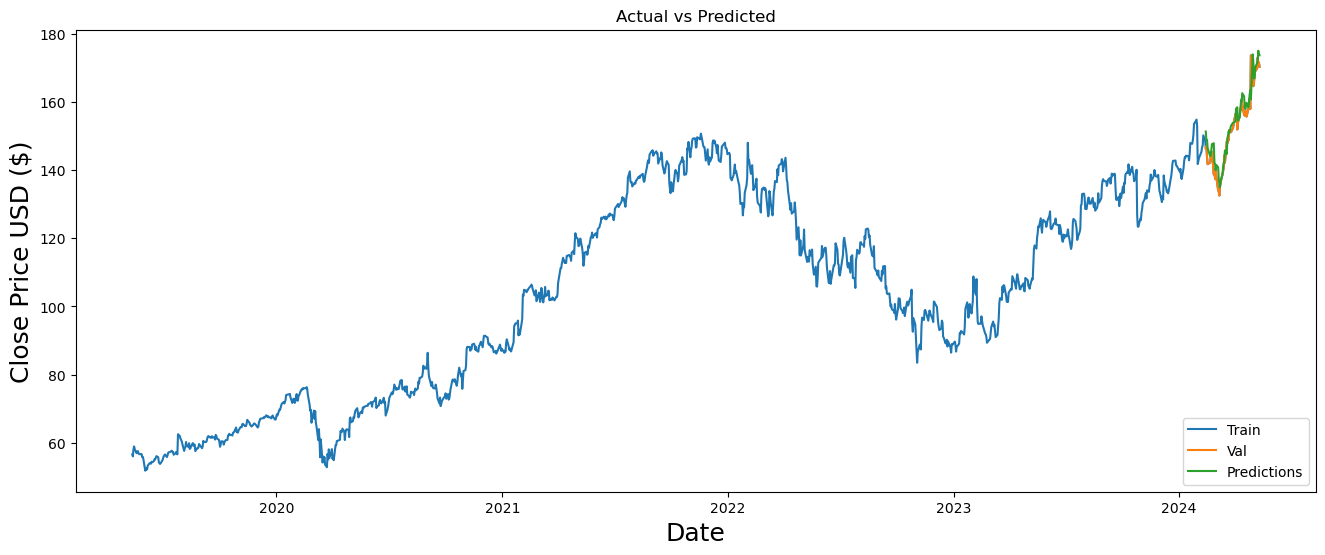

In [190]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_goog_5['Close'])
plt.plot(valid_goog[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [191]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_goog_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_goog[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Hold the stock.


#### Apple Prediction

In [192]:
df_aapl_5, valid_aapl, pred_aapl = preprocess_data(comp_list[3])

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 12ms/step


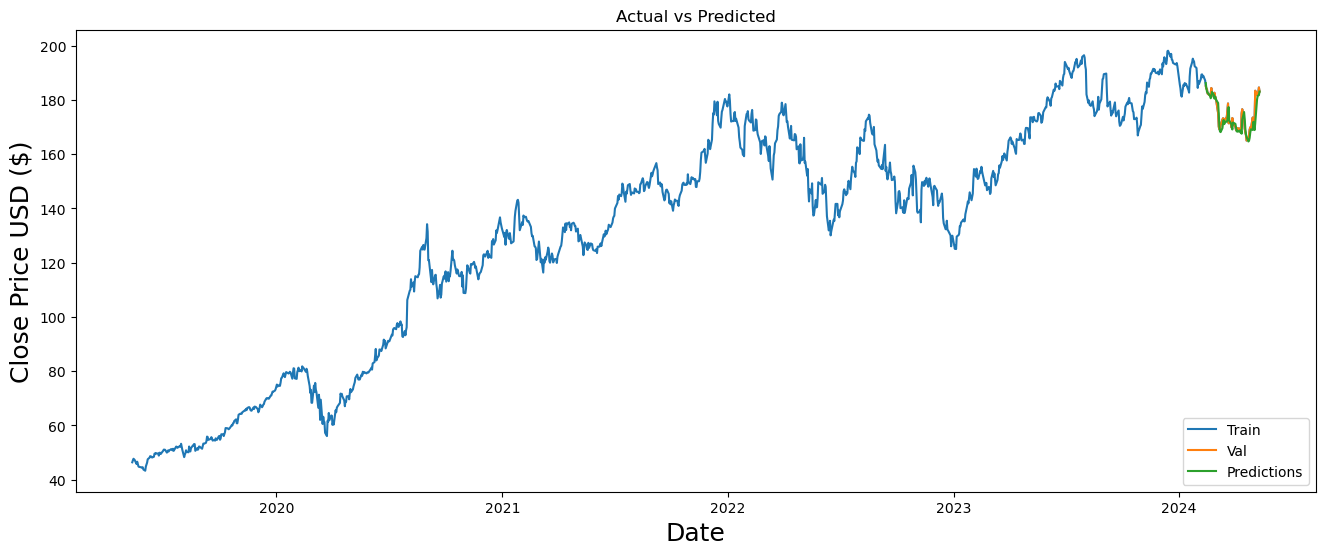

In [193]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_aapl_5['Close'])
plt.plot(valid_aapl[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [194]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_aapl_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_aapl[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Hold the stock.


### Conclusion

Over the 3 stocks, Apple and Microsoft have the closest correlation in performance as compared to Google. A close eye in Apple and Microsoft performance would be recommended as there are chances that both stocks may experience drastic increase in stock price regarding their recent annoucements in products and the AI boom. For each stock, the model predicts that it would be best to hold onto any stock you may have and not buy their stock. 

Considering Google's performance and downward trend, holding onto any stock you have is ideal as you will have to ride out its stock drop until it can recover. Regarding its drop, there are high chances it will continue to drop and it would be best to wait until the drop begins to curve and begin to invest before it goes back up.

Microsoft has been experiencing exceptional performance in recent months regarding its performance reports and becoming viewed as the most valuable company, beating Apple in stock performance. There are chances that the stock will increase in value as it continues to experience an upward trend that beats its moving average. It would be best to hold the stock. If there were plans to purchase stock, it would not be recommended to do so and wait for a sudden drop instead. Purchase in the stock would not lead to fast recovery and instead possible loss considering how drastically different Microsoft's stock to other popular tech stocks, it may be overvalued.

Viewing Apple's stock performance, it experiences a stock performance that randomly experiences up and down trends. Although it did experience a significant upward trend in 2023. It has been struggling to maintain that trend. The stock is seen to be struggling to keep up with its moving average. With the stock's recent performance and model, it would be recommended to hold any stock you may have purchased and not to sell, if you plan to buy, do not purchase a large amount of the stock. Purchasing the stock can lead to a possible return regarding Apple's recent annoucement with its new M4 Chip, it has been now experiencing an upward trend but not enough to fully encourage buying as much as possible.

## Goldman Sachs Analysis